# Objective

Our goal is to quantify the top topics classified for each CB meeting. This will provide a comparison with 311 service request data. 

For each CB, what is the top topics discussed?

**Input:**

    - JSON object of public archive of Community Board meetings
    - Dictionary of topics with probabilities assigned to each topic in the taxonomy.

**Output:**

    - Structured dataframe:
        - Each CB ID, link to full transcript
        - Topic as binary one-hot-encoding column if over a threshold
  

In [202]:
import pandas as pd
import json
import datetime
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

### Data

In [154]:
# list of topics
topics_tax = ['Parks', 'Housing', 'Land Use', 'Infrastructure', 'Transportation',
              'Quality of Life', 'Safety', 'Waterfront', 'Technology', 'Zoning',
              'Commercial Development', 'Equity', 'Arts and Culture', 'Youth',
              'Census', 'Seniors', 'Employment', 'Health', 'Licensing',
              'Utilities', 'Human Services', 'Budget', 'Libraries',
              'Education', 'Sanitation', 'Police', 'Elections']

In [156]:
print(topics_tax)

['Parks', 'Housing', 'Land Use', 'Infrastructure', 'Transportation', 'Quality of Life', 'Safety', 'Waterfront', 'Technology', 'Zoning', 'Commercial Development', 'Equity', 'Arts and Culture', 'Youth', 'Census', 'Seniors', 'Employment', 'Health', 'Licensing', 'Utilities', 'Human Services', 'Budget', 'Libraries', 'Education', 'Sanitation', 'Police', 'Elections']


In [23]:
file = '../../Data/transcripts_v4.json'
with open(file) as train_file:
    dict_train = json.load(train_file)

In [9]:
len(dict_train)

3102

In [12]:
dict_train[0].get('_id')

{'$oid': '5fe7e243539a4d487dc18b64'}

In [13]:
def structure_df(input_db_query):
    import pandas as pd
    obj_id = []
    video_url = []
    author = []
    publish_date = []
    title = []
    topic = []
    full_transcript = []
    word_count_list = []
    length = []
    for id in input_db_query:
        obj_id.append(str(id.get('_id')))
        video_url.append(str(id.get('properties').get('videoURL')))
        author.append(str(id.get('CommunityBoardInfo').get('normalizedName')))
        publish_date.append(id.get('YoutubeMetadata').get('publishDate'))
        title.append(str(id.get('YoutubeMetadata').get('title')))
        topic.append(str(id.get('properties').get('meetingType')))
        full_transcript.append(str(id.get('properties').get('fullTranscript')))
        length.append(str(id.get('YoutubeMetadata').get('lengthSeconds')))
        # get list of key words
        word_count_dict = id.get('properties').get('wordCountFullTranscript')
        word_count_dict.update(id.get('properties').get('wordCountSummary'))
        #word_count = list(dict(list(full_word_count.items()) + list(summary_word_count.items())).keys())
        #print(word_count)
        # make into dictionary
        word_count_list.append(word_count_dict)
    
    # make each list into dataframe
    output_df = pd.DataFrame(
    {'obj_id': obj_id,
     'video_url': video_url,
     'author': author,
     'publish_date': publish_date,
     'title': title,
     'topic': topic,
     'fullTranscript': full_transcript,
     'word_count': word_count_list,
     'length':length
    })

    return output_df

In [19]:
df = structure_df(dict_train)

In [20]:
df.head()

,obj_id,video_url,author,publish_date,title,topic,fullTranscript,word_count,length
0,{'$oid': '5fe7e243539a4d487dc18b64'},9WyiCFkYBrk,Brooklyn Community Board 6,2020-05-07T00:00:00,COMMUNITY CHECK IN,"[[0.4210607409477234, 'Budget'], [0.1910649240...",A great turnout and it seemed like it- went pr...,"{'state': 17, 'businesses': 7, 'nursing': 7, '...",1:42:02
1,{'$oid': '5fe7e243539a4d487dc18b65'},tv-N4M_zCT4,Brooklyn Community Board 8,2020-11-06T00:00:00,Land Use Committee,"[[0.4097696840763092, 'Landmarks'], [0.3762851...","Good at it today, let's see okay, so there see...","{'building': 17, 'landmarks': 9, 'units': 5, '...",2:45:00
2,{'$oid': '5fe7e243539a4d487dc18b66'},Ftq9Z4DFmE4,Manhattan Community Board 2,2020-10-23T00:00:00,Monthly Meeting,"[[0.5453713536262512, 'Safety'], [0.0701165199...","Okay, we're gonna get started. Welcome. Tonigh...","{'restaurants': 6, 'dining': 7, 'plan': 5, 're...",2:22:36
3,{'$oid': '5fe7e243539a4d487dc18b67'},wulekhvNcIk,Manhattan Community Board 3,2020-05-12T00:00:00,"Manhattan, Landmarks Committee meeting","[[0.2568089962005615, 'Employment'], [0.245191...","Okay, there you go yep, so welcome everybody t...","{'tile': 4, 'facade': 5, 'staff': 9, 'residenc...",0:33:51
4,{'$oid': '5fe7e243539a4d487dc18b68'},OVHshrqxRgo,Manhattan Community Board 5,2020-11-06T00:00:00,Landmarks Committee Meeting,"[[0.09517455846071243, 'Land Use'], [0.0794066...","Okay, so it looks like Paul just joined us, ok...","{'sign': 19, 'building': 17, 'plan': 5, 'maste...",1:02:10


### Preprocessing

    0. Filter down to the last 6 months (August 01, 2021 - Feb 26, 2022)
    1. Remove any non-CB meeting
    2. Create column for each value in the topic value probability if over threshold.
    3. Define threshold for each topic dictionary
    4. Group by CB and identify top meeting topic

#### Filter down to the last 6 months

In [24]:
df[df.publish_date > '2021-08-01'].shape

(1044, 9)

In [25]:
df = df[df.publish_date > '2021-08-01']

#### filter out anything that is not a CB meeting

In [43]:
# how many non-CB
df[~df['author'].str.contains('Community')].shape

(71, 10)

In [44]:
df = df[df['author'].str.contains('Community')]

In [50]:
df.head()

,obj_id,video_url,author,publish_date,title,topic,fullTranscript,word_count,length,seconds
2058,{'$oid': '610a755500409f3bf834a3a6'},dngxZ4nvtRM,Manhattan Community Board 1,2021-08-03T00:00:00,"Land Use, Zoning & Economic Development","[[0.061796315014362335, 'Infrastructure'], [0....","Welcome to the March 2020 land use, zoning and...","{'design': 8, 'space': 4, 'workshop': 5, 'buil...",1:25:04,5104
2059,{'$oid': '610a75e500409f3bf834a3a8'},o-phHhpweNE,Manhattan Community Board 1,2021-08-03T00:00:00,Landmarks & Preservation,"[[0.5668426156044006, 'Safety'], [0.0611808523...","In the main, exhibit space most of the work wi...","{'building': 5, 'space': 6, 'sign': 5, 'street...",1:07:18,4038
2060,{'$oid': '610bcb2c319bd70e4e39d404'},P1epq8hnxhc,Manhattan Community Board 1,2021-08-04T00:00:00,Licensing & Permits,"[[0.3489021360874176, 'Licensing'], [0.0711944...","Business for a minute, not yet so to the commi...","{'tables': 10, 'cafe': 9, 'restaurant': 5, 'ho...",1:52:23,6743
2061,{'$oid': '610bcb94319bd70e4e39d406'},BwksV_B3JJI,Brooklyn Community Board 7,2021-08-04T00:00:00,Transportation Committee Meeting,"[[0.3860085904598236, 'Transportation'], [0.07...","Actually, you can make your co-host as well, s...","{'street': 41, 'truck': 19, 'avenue': 18, 'tra...",1:37:11,5831
2062,{'$oid': '610c7cae9e0f346bfc1e64b6'},ZjTfKqtf5a0,Manhattan Community Board 1,2021-08-05T00:00:00,Youth and Education,"[[0.36873799562454224, 'Census'], [0.283629685...","And then you know, we don't I think I'm not go...","{'pier': 4, 'school': 5, 'kids': 13, 'census':...",0:37:50,2270


In [45]:
# total number of transcripts
len(df)

973

In [46]:
# What is the average length of a meeting?

def get_sec(time_str):
    """Get Seconds from time."""
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)


print(get_sec(df.length.head()[2058]))

5104


- Convert to seconds
- Convert back to hours:minutes:seconds

In [51]:
df['seconds'] = df.length.apply(lambda x: get_sec(x))

In [52]:
df['seconds'].mean()

6583.105858170607

In [53]:
# Average length of meeting over the last 6 months
str(datetime.timedelta(seconds=df['seconds'].mean()))

'1:49:43.105858'

In [39]:
# What was the longest meeting?

In [54]:
df['length'].max()

'6:19:13'

In [61]:
# which meeting was this?
df[df['length'] == df['length'].max()]

,obj_id,video_url,author,publish_date,title,topic,fullTranscript,word_count,length,seconds
2182,{'$oid': '61435d5dd38e0dc51836be58'},LGOU_YFtNo8,Brooklyn Community Board 1,2021-09-15T00:00:00,Combined Public Hearing and Board Meeting,"[[0.2225257307291031, 'Parks'], [0.20844766497...",Call to order public hearing jerry can I have ...,"{'project': 47, 'bridge': 15, 'conditions': 33...",6:19:13,22753


In [60]:
# topics discussed
print(df[df['length'] == df['length'].max()].word_count.values)

[{'project': 47, 'bridge': 15, 'conditions': 33, 'street': 14, 'building': 19, 'space': 22, 'traffic': 81, 'housing': 21, 'park': 18, 'neighborhood': 64, 'land': 16, 'river': 15}]


The longest community board meeting from the last 6 months was 6 hours, 19 minutes, and 13 seconds. It was from Brooklyn Community Board 1 for a Combined Public Hearing and Board Meeting about Williamsburg River Ring Proposal that was eventually approved for rezoning in this meeting.

Here is a related link: https://brooklyneagle.com/articles/2021/09/15/its-official-community-board-1-approves-transformative-river-ring/

In [71]:
# For each Topic, output probability. We will visualize the mean and distributions.

How to define threshold:

**Background:**

Multi-class zero-shot learning from HuggingFace.
    - softmax logit function
    - output probability [0,1] for each candidate label
    - each candidate label probability is independent and therefore do not sum to 1

When multi_class=True, we do a softmax over entailment vs contradiction for each candidate label independently, i.e. logits[:,[0,-1]].softmax(dim=1)[:,-1]. This gives a probability for each candidate label between 0 and 1, but they are independent and do not sum to 1.

#### Create column for each topic

Since it is a multi-class each meeting will have all the candidate topics as column header. 

In [72]:
# convert to literal value
df.topic = df.topic.apply(lambda x: ast.literal_eval(x))

In [120]:
#df.head(1)['topic'].values[0]

In [113]:
pd.DataFrame(df.head(1)['topic'].values[0])[[1,0]].T

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
1,Infrastructure,Seniors,Waterfront,Youth,Parks,Land Use,Zoning,Housing,Safety,Equity,...,Commercial Development,Utilities,Licensing,Education,Census,Libraries,Sanitation,Human Services,Budget,Elections
0,0.061796,0.056422,0.049222,0.048046,0.045914,0.044729,0.043673,0.04128,0.041079,0.04033,...,0.036188,0.033453,0.031418,0.027865,0.027192,0.026341,0.024352,0.021665,0.017706,0.009059


In [ ]:
# convert to dictionary

In [123]:
df.topic = df.topic.apply(lambda x: {k[0]: k[1:] for k in x})

In [125]:
# switch the order
df.topic =  df.topic.apply(lambda topic_dict : dict((y[0],x) for x,y in topic_dict.items()))

In [126]:
df.topic.head()

2058    {'Infrastructure': 0.061796315014362335, 'Seni...
2059    {'Safety': 0.5668426156044006, 'Housing': 0.06...
2060    {'Licensing': 0.3489021360874176, 'Quality of ...
2061    {'Transportation': 0.3860085904598236, 'Infras...
2062    {'Census': 0.36873799562454224, 'Parks': 0.283...
Name: topic, dtype: object

In [162]:
# Create empty columns for each topic
df = pd.concat([df, df.reindex(columns=list(topics_tax))], axis=1)

In [163]:
df.head(1)

,obj_id,video_url,author,publish_date,title,topic,fullTranscript,word_count,length,seconds,...,Health,Licensing,Utilities,Human Services,Budget,Libraries,Education,Sanitation,Police,Elections
2058,{'$oid': '610a755500409f3bf834a3a6'},dngxZ4nvtRM,Manhattan Community Board 1,2021-08-03T00:00:00,"Land Use, Zoning & Economic Development","{'Infrastructure': 0.061796315014362335, 'Seni...","Welcome to the March 2020 land use, zoning and...","{'design': 8, 'space': 4, 'workshop': 5, 'buil...",1:25:04,5104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For each column fill with value from dictionary

In [164]:
test = df[df['length'] == df['length'].max()]

In [186]:
topics_tax

['Parks',
 'Housing',
 'Land Use',
 'Infrastructure',
 'Transportation',
 'Quality of Life',
 'Safety',
 'Waterfront',
 'Technology',
 'Zoning',
 'Commercial Development',
 'Equity',
 'Arts and Culture',
 'Youth',
 'Census',
 'Seniors',
 'Employment',
 'Health',
 'Licensing',
 'Utilities',
 'Human Services',
 'Budget',
 'Libraries',
 'Education',
 'Sanitation',
 'Police',
 'Elections']

In [190]:
for i in topics_tax:
    test[i] = test.topic.apply(lambda x: x.get(i))

<ipython-input-190-14e6ee300b32>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i] = test.topic.apply(lambda x: x.get(i))


In [191]:
test

,obj_id,video_url,author,publish_date,title,topic,fullTranscript,word_count,length,seconds,Parks,Housing,Land Use,Infrastructure,Transportation,Quality of Life,Safety,Waterfront,Technology,Zoning,Commercial Development,Equity,Arts and Culture,Youth,Census,Seniors,Employment,Health,Licensing,Utilities,Human Services,Budget,Libraries,Education,Sanitation,Police,Elections
2182,{'$oid': '61435d5dd38e0dc51836be58'},LGOU_YFtNo8,Brooklyn Community Board 1,2021-09-15T00:00:00,Combined Public Hearing and Board Meeting,"{'Parks': 0.2225257307291031, 'Housing': 0.208...",Call to order public hearing jerry can I have ...,"{'project': 47, 'bridge': 15, 'conditions': 33...",6:19:13,22753,0.222526,0.208448,0.189873,0.159264,0.059212,0.042353,0.016891,0.015579,0.009441,0.009109,0.00749,0.007298,0.006257,0.006143,0.005859,0.005551,0.004672,0.004229,0.003153,0.002986,0.002567,0.002473,0.002145,0.001873,0.001737,0.001615,0.001256


In [192]:
for i in topics_tax:
    df[i] = df.topic.apply(lambda x: x.get(i))

In [193]:
df.head()

,obj_id,video_url,author,publish_date,title,topic,fullTranscript,word_count,length,seconds,Parks,Housing,Land Use,Infrastructure,Transportation,Quality of Life,Safety,Waterfront,Technology,Zoning,Commercial Development,Equity,Arts and Culture,Youth,Census,Seniors,Employment,Health,Licensing,Utilities,Human Services,Budget,Libraries,Education,Sanitation,Police,Elections
2058,{'$oid': '610a755500409f3bf834a3a6'},dngxZ4nvtRM,Manhattan Community Board 1,2021-08-03T00:00:00,"Land Use, Zoning & Economic Development","{'Infrastructure': 0.061796315014362335, 'Seni...","Welcome to the March 2020 land use, zoning and...","{'design': 8, 'space': 4, 'workshop': 5, 'buil...",1:25:04,5104,0.045914,0.041280,0.044729,0.061796,0.039568,0.039262,0.041079,0.049222,0.038071,0.043673,0.036188,0.040330,0.039233,0.048046,0.027192,0.056422,0.039916,0.039297,0.031418,0.033453,0.021665,0.017706,0.026341,0.027865,0.024352,0.036923,0.009059
2059,{'$oid': '610a75e500409f3bf834a3a8'},o-phHhpweNE,Manhattan Community Board 1,2021-08-03T00:00:00,Landmarks & Preservation,"{'Safety': 0.5668426156044006, 'Housing': 0.06...","In the main, exhibit space most of the work wi...","{'building': 5, 'space': 6, 'sign': 5, 'street...",1:07:18,4038,0.009537,0.061181,0.016841,0.026293,0.007849,0.047765,0.566843,0.013764,0.008692,0.008414,0.036526,0.012365,0.041751,0.013767,0.006058,0.011357,0.029886,0.012163,0.025517,0.013788,0.003797,0.007291,0.003867,0.003475,0.003465,0.005798,0.001950
2060,{'$oid': '610bcb2c319bd70e4e39d404'},P1epq8hnxhc,Manhattan Community Board 1,2021-08-04T00:00:00,Licensing & Permits,"{'Licensing': 0.3489021360874176, 'Quality of ...","Business for a minute, not yet so to the commi...","{'tables': 10, 'cafe': 9, 'restaurant': 5, 'ho...",1:52:23,6743,0.029161,0.013302,0.019226,0.016522,0.015708,0.071194,0.041244,0.030502,0.019864,0.025603,0.026338,0.044275,0.020947,0.036984,0.041070,0.031636,0.045766,0.034821,0.348902,0.017671,0.010788,0.020219,0.010306,0.010597,0.006926,0.004249,0.006179
2061,{'$oid': '610bcb94319bd70e4e39d406'},BwksV_B3JJI,Brooklyn Community Board 7,2021-08-04T00:00:00,Transportation Committee Meeting,"{'Transportation': 0.3860085904598236, 'Infras...","Actually, you can make your co-host as well, s...","{'street': 41, 'truck': 19, 'avenue': 18, 'tra...",1:37:11,5831,0.026333,0.011344,0.047123,0.070630,0.386009,0.067881,0.042146,0.020450,0.024307,0.022833,0.016072,0.043127,0.008197,0.026501,0.020633,0.018363,0.030260,0.021319,0.017726,0.019709,0.005683,0.012857,0.006987,0.007613,0.015458,0.005716,0.004722
2062,{'$oid': '610c7cae9e0f346bfc1e64b6'},ZjTfKqtf5a0,Manhattan Community Board 1,2021-08-05T00:00:00,Youth and Education,"{'Census': 0.36873799562454224, 'Parks': 0.283...","And then you know, we don't I think I'm not go...","{'pier': 4, 'school': 5, 'kids': 13, 'census':...",0:37:50,2270,0.283630,0.003258,0.004372,0.028956,0.005038,0.016468,0.011150,0.075382,0.004810,0.002656,0.002833,0.011485,0.004543,0.072410,0.368738,0.003090,0.007429,0.003294,0.004664,0.004240,0.003832,0.007683,0.002877,0.060050,0.002799,0.002682,0.001634


In [194]:
df.columns

Index(['obj_id', 'video_url', 'author', 'publish_date', 'title', 'topic',
       'fullTranscript', 'word_count', 'length', 'seconds', 'Parks', 'Housing',
       'Land Use', 'Infrastructure', 'Transportation', 'Quality of Life',
       'Safety', 'Waterfront', 'Technology', 'Zoning',
       'Commercial Development', 'Equity', 'Arts and Culture', 'Youth',
       'Census', 'Seniors', 'Employment', 'Health', 'Licensing', 'Utilities',
       'Human Services', 'Budget', 'Libraries', 'Education', 'Sanitation',
       'Police', 'Elections'],
      dtype='object')

In [195]:
# Export to csv
df[['obj_id', 'video_url', 'author', 'publish_date', 'title', 'topic',
        'word_count', 'length', 'seconds', 'Parks', 'Housing',
       'Land Use', 'Infrastructure', 'Transportation', 'Quality of Life',
       'Safety', 'Waterfront', 'Technology', 'Zoning',
       'Commercial Development', 'Equity', 'Arts and Culture', 'Youth',
       'Census', 'Seniors', 'Employment', 'Health', 'Licensing', 'Utilities',
       'Human Services', 'Budget', 'Libraries', 'Education', 'Sanitation',
       'Police', 'Elections']].to_csv('odw_topics_archive.csv',index=False)

#### Remove any topic if below threshold, how to define threshold?

Any below .05 for simplicty sake fill with NA. 

With more dev, we could define threholds based on distributions.

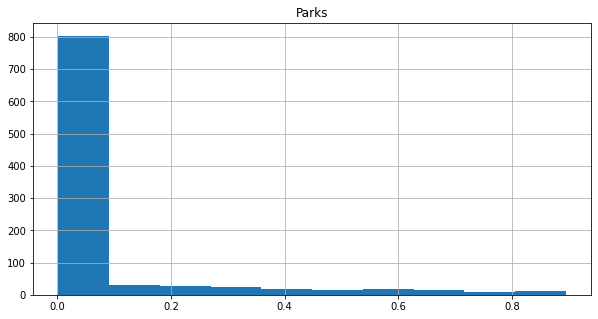

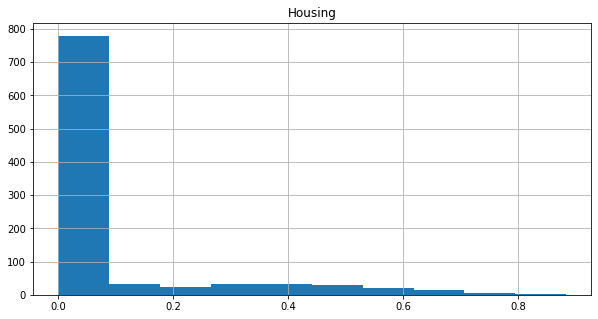

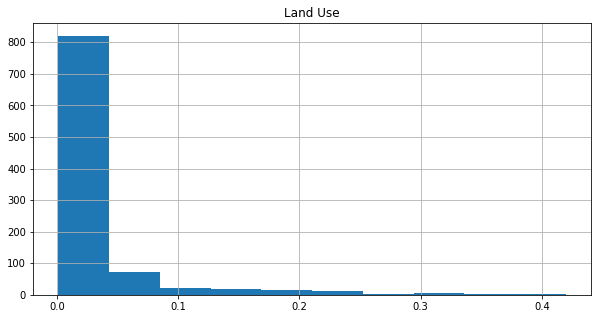

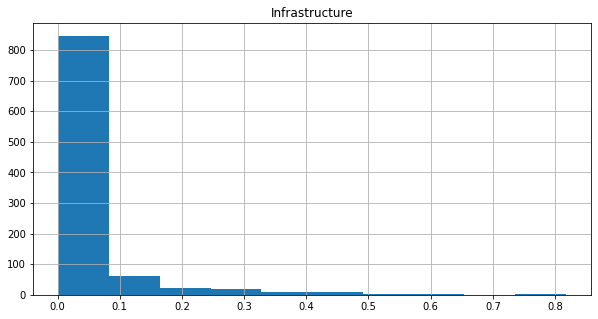

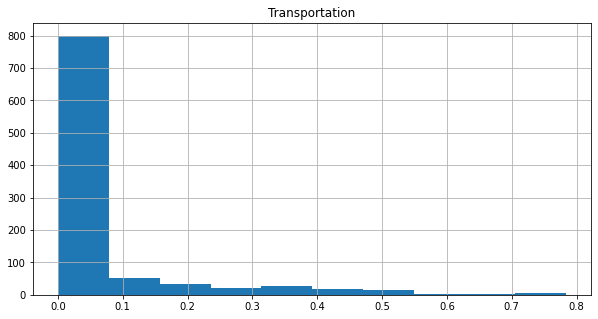

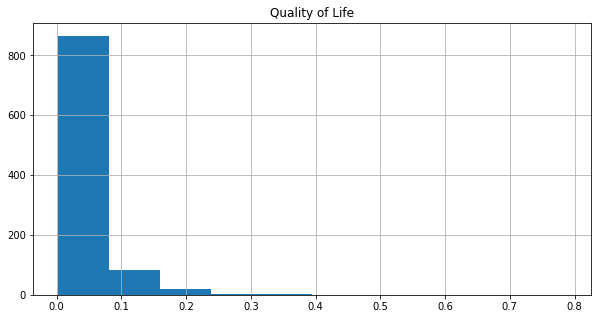

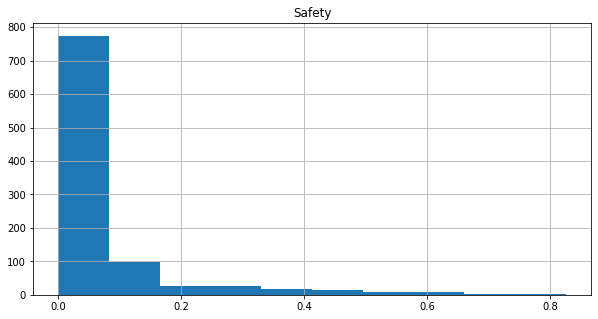

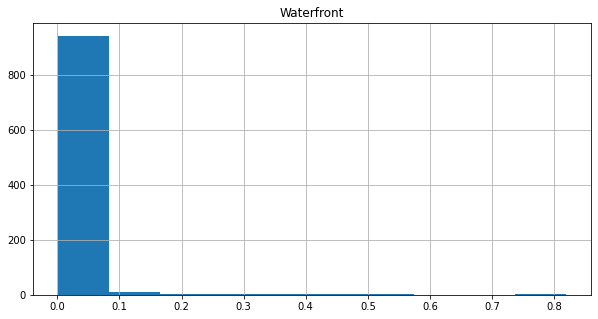

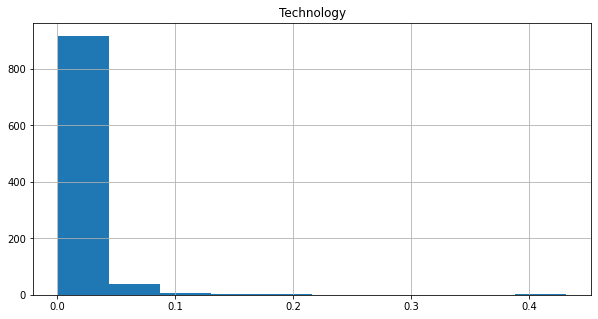

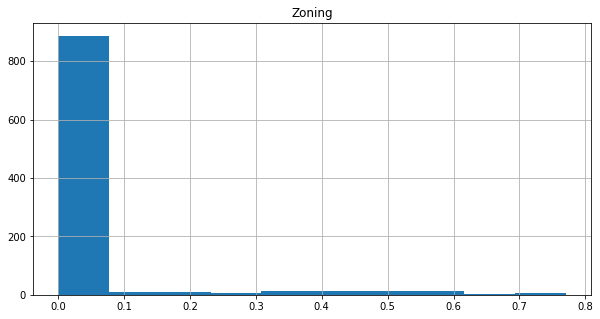

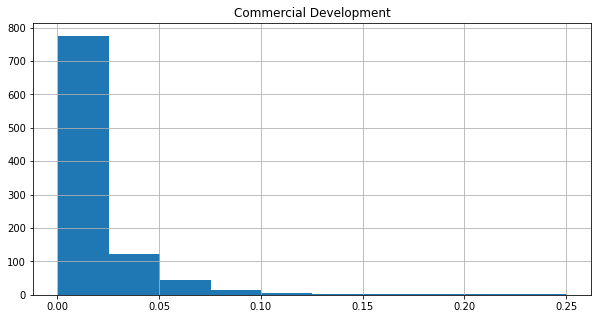

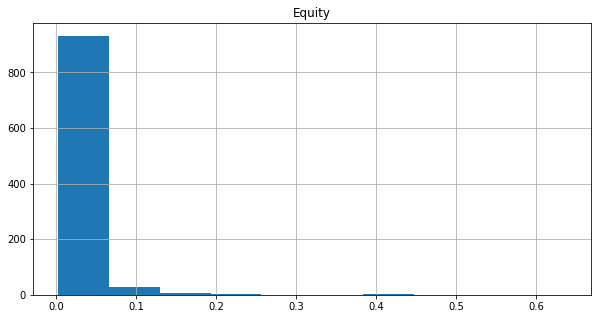

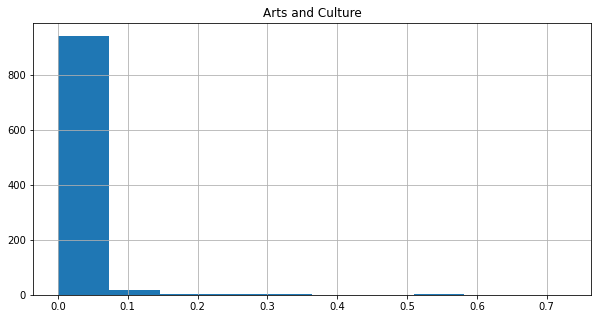

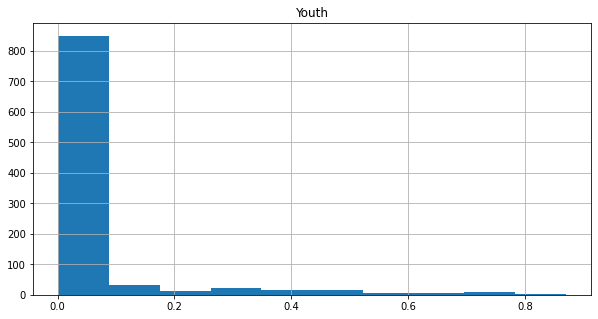

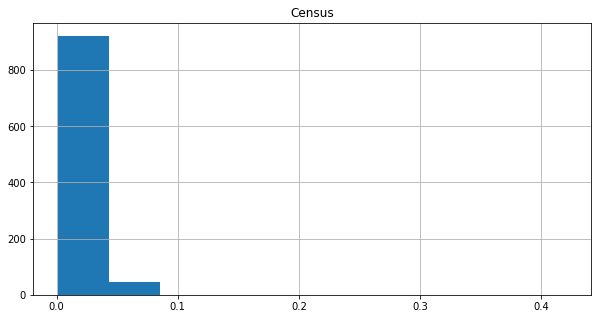

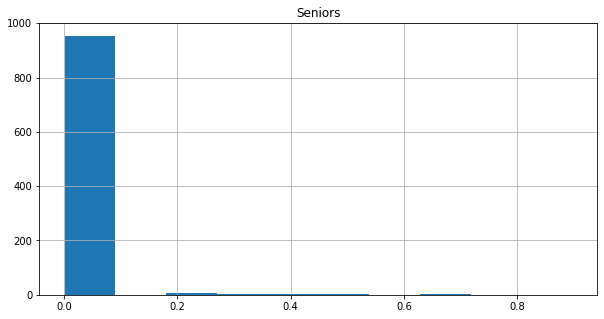

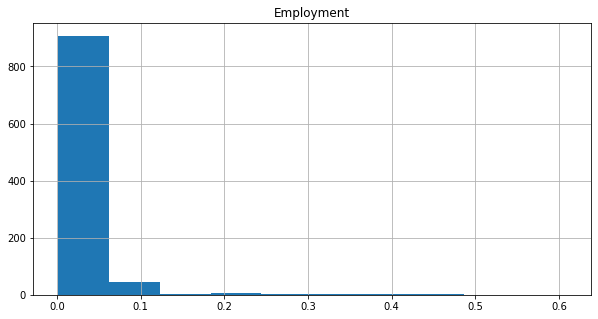

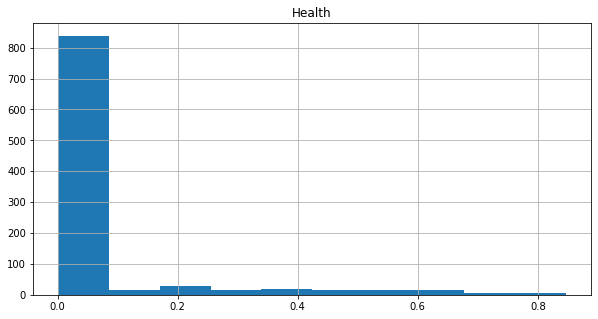

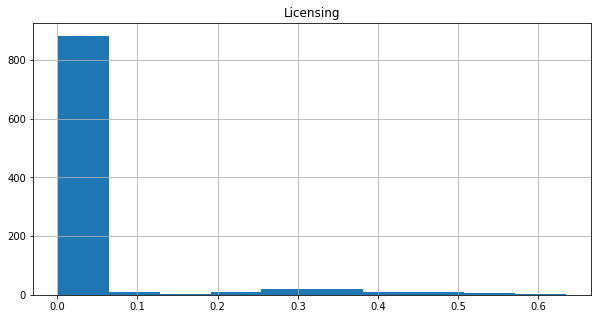

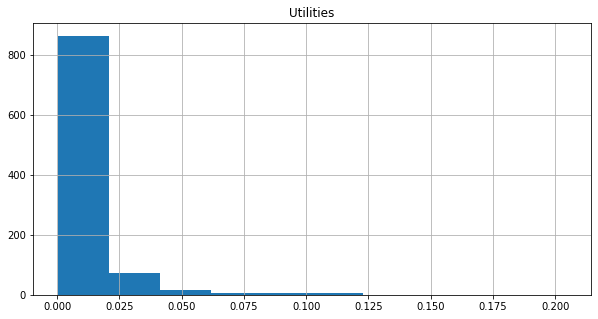

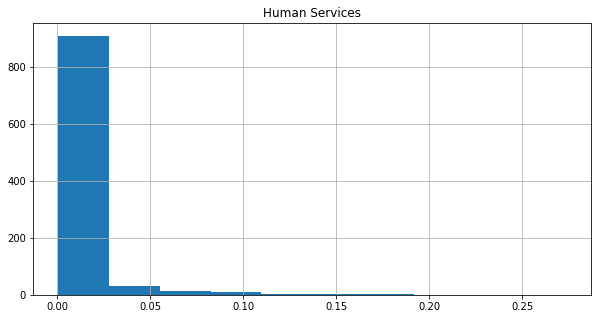

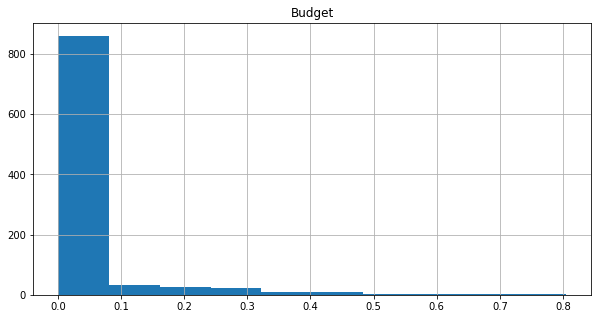

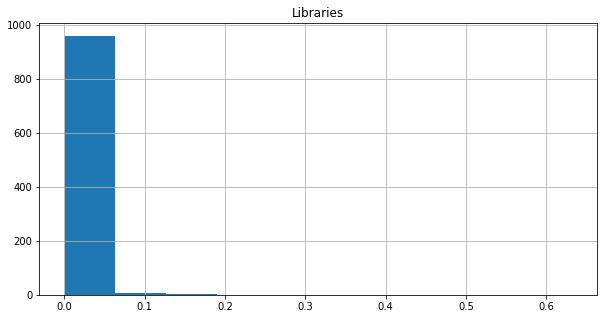

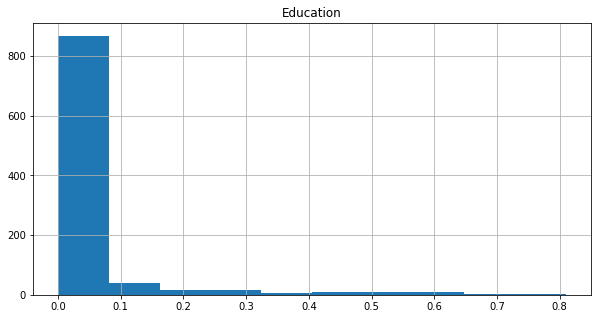

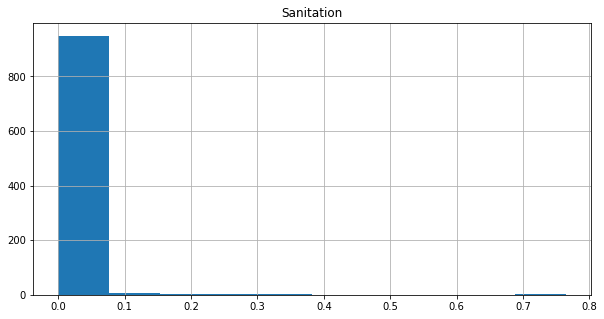

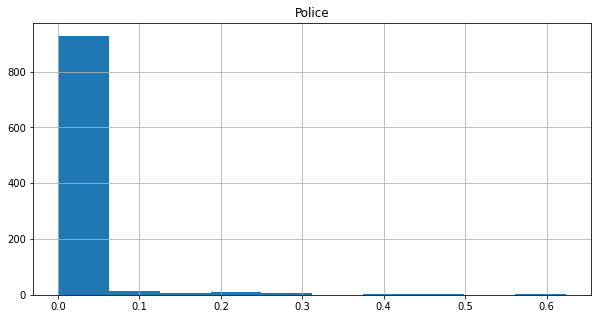

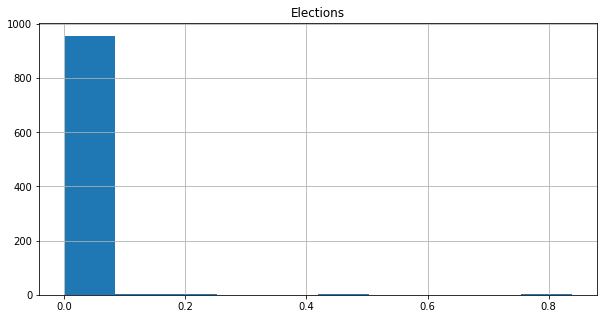

In [233]:
# Distributions
for i in topics_tax:
    plt.figure(figsize=(10, 5))
    df[i].hist()
    plt.title(i)
    plt.show()

We see from distributions that most topics in dictionaries do not have any relevance to the candidate topic. We see majority are below .05

In [ ]:
# fill with nan if the value is below .05

In [235]:
for i in topics_tax:
    df[i] = df[i].apply(lambda x: np.nan if x < .05 else x)

In [ ]:
df[topics_tax] = df[topics_tax].mask(df[topics_tax] < df.quantile())

### EDA

In [197]:
# before removing below threshold
df[topics_tax].describe()

,Parks,Housing,Land Use,Infrastructure,Transportation,Quality of Life,Safety,Waterfront,Technology,Zoning,Commercial Development,Equity,Arts and Culture,Youth,Census,Seniors,Employment,Health,Licensing,Utilities,Human Services,Budget,Libraries,Education,Sanitation,Police,Elections
count,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,0.089620,0.086402,0.030400,0.048077,0.063643,0.044907,0.074393,0.028237,0.016613,0.046438,0.017174,0.029612,0.017064,0.064507,0.018268,0.025513,0.026725,0.070061,0.041858,0.011808,0.011150,0.045444,0.009030,0.039617,0.013744,0.017686,0.012008
std,0.177109,0.169905,0.055378,0.083024,0.126695,0.049487,0.114354,0.067494,0.030976,0.125859,0.025576,0.036421,0.048370,0.134269,0.022703,0.068546,0.046039,0.151226,0.103404,0.016330,0.019998,0.104285,0.028295,0.105878,0.057507,0.062329,0.067875
min,0.002045,0.000553,0.001342,0.001429,0.000743,0.002893,0.001035,0.001675,0.000981,0.000549,0.000557,0.002746,0.000817,0.001560,0.001549,0.001002,0.001765,0.001401,0.001396,0.000520,0.000660,0.001043,0.000574,0.000607,0.000413,0.000451,0.000431
25%,0.011121,0.005341,0.005831,0.009407,0.006189,0.018244,0.017483,0.008798,0.005045,0.004167,0.003483,0.013711,0.003890,0.010605,0.007662,0.007325,0.008110,0.007314,0.005706,0.003982,0.003548,0.005871,0.002920,0.003556,0.002842,0.002336,0.001810
50%,0.019980,0.010864,0.011203,0.020204,0.012147,0.032318,0.035183,0.014259,0.009026,0.008154,0.007699,0.022293,0.006865,0.019903,0.013306,0.012925,0.015143,0.014910,0.009861,0.007301,0.006027,0.012233,0.004786,0.006075,0.004515,0.004160,0.002940
75%,0.041238,0.036334,0.024651,0.045141,0.042188,0.054716,0.066798,0.024665,0.017258,0.017349,0.020115,0.036479,0.013370,0.038380,0.023187,0.022854,0.028404,0.031659,0.018480,0.013301,0.010247,0.023952,0.008380,0.014349,0.007604,0.008550,0.005019
max,0.894679,0.882250,0.419741,0.817187,0.783226,0.786366,0.825786,0.818726,0.430871,0.770211,0.249742,0.637357,0.727166,0.869375,0.420207,0.896411,0.607982,0.846435,0.634281,0.204258,0.273357,0.804109,0.632141,0.809642,0.764341,0.623553,0.838653


In [240]:
# after
df[topics_tax].describe()

,Parks,Housing,Land Use,Infrastructure,Transportation,Quality of Life,Safety,Waterfront,Technology,Zoning,Commercial Development,Equity,Arts and Culture,Youth,Census,Seniors,Employment,Health,Licensing,Utilities,Human Services,Budget,Libraries,Education,Sanitation,Police,Elections
count,219.000000,217.000000,135.000000,219.000000,222.000000,285.000000,352.000000,71.000000,49.000000,99.000000,77.000000,96.000000,40.000000,183.000000,37.000000,45.000000,99.000000,168.000000,94.000000,31.000000,34.000000,142.000000,13.000000,137.000000,32.000000,49.000000,22.000000
mean,0.336552,0.349405,0.139167,0.152828,0.236988,0.092302,0.164351,0.179554,0.109166,0.365072,0.084950,0.092726,0.187246,0.262795,0.083667,0.229853,0.115749,0.333844,0.327241,0.083750,0.097838,0.237741,0.199999,0.233207,0.248336,0.237400,0.355391
std,0.245810,0.200398,0.088077,0.126552,0.176442,0.069591,0.152384,0.191638,0.092068,0.205335,0.042454,0.088377,0.159403,0.216832,0.080283,0.237610,0.104722,0.219009,0.141351,0.035482,0.046819,0.175577,0.149183,0.189207,0.210522,0.161321,0.293437
min,0.050263,0.050185,0.050545,0.050236,0.050191,0.050124,0.050355,0.050323,0.050012,0.050859,0.050313,0.050038,0.050916,0.050091,0.051102,0.050330,0.050087,0.050340,0.050108,0.050098,0.051735,0.050857,0.082243,0.052107,0.050175,0.053467,0.051728
25%,0.104177,0.173578,0.068519,0.069022,0.085727,0.059439,0.063824,0.058075,0.057080,0.200337,0.059768,0.056509,0.083427,0.072213,0.052779,0.055445,0.058312,0.133706,0.253698,0.058362,0.065031,0.092283,0.109810,0.087762,0.079967,0.110889,0.090576
50%,0.275333,0.338803,0.106143,0.097661,0.181788,0.071745,0.092468,0.076196,0.072687,0.382155,0.070472,0.063067,0.123319,0.175793,0.057701,0.073509,0.075011,0.320094,0.329904,0.076242,0.083317,0.196183,0.149268,0.150766,0.178229,0.195014,0.223570
75%,0.533301,0.497320,0.188423,0.187862,0.358550,0.096456,0.211128,0.227990,0.112329,0.524502,0.091185,0.078151,0.262522,0.404569,0.067408,0.352980,0.115269,0.516107,0.421497,0.094648,0.111477,0.303226,0.225324,0.310238,0.342966,0.307513,0.628878
max,0.894679,0.882250,0.419741,0.817187,0.783226,0.786366,0.825786,0.818726,0.430871,0.770211,0.249742,0.637357,0.727166,0.869375,0.420207,0.896411,0.607982,0.846435,0.634281,0.204258,0.273357,0.804109,0.632141,0.809642,0.764341,0.623553,0.838653


In [201]:
df[topics_tax].corr()

,Parks,Housing,Land Use,Infrastructure,Transportation,Quality of Life,Safety,Waterfront,Technology,Zoning,Commercial Development,Equity,Arts and Culture,Youth,Census,Seniors,Employment,Health,Licensing,Utilities,Human Services,Budget,Libraries,Education,Sanitation,Police,Elections
Parks,1.000000,-0.162871,-0.070352,0.000404,-0.116132,-0.014066,-0.130350,0.019718,-0.078497,-0.132982,-0.144897,-0.122681,-0.011128,-0.104359,-0.121114,-0.083572,-0.100349,-0.135661,-0.105465,-0.079342,-0.142336,-0.037583,-0.048007,-0.118504,-0.050557,-0.037750,-0.043461
Housing,-0.162871,1.000000,0.095220,-0.106765,-0.186010,-0.135744,-0.103050,-0.080640,-0.117660,-0.020906,-0.070064,-0.082219,-0.089072,-0.132829,-0.065147,-0.032812,-0.025706,-0.067683,-0.136296,-0.103198,0.172933,-0.003432,-0.068534,-0.128291,-0.063155,-0.092747,-0.058797
Land Use,-0.070352,0.095220,1.000000,-0.015517,-0.040107,-0.035406,-0.114637,-0.008899,-0.025679,0.316860,0.224720,-0.035232,-0.024785,-0.135011,0.033686,-0.048553,0.005657,-0.134591,-0.060936,-0.019649,-0.090353,-0.079136,-0.021703,-0.104692,-0.055145,-0.070974,-0.042054
Infrastructure,0.000404,-0.106765,-0.015517,1.000000,0.138759,-0.000103,-0.002027,0.014574,0.122568,-0.092066,0.033443,-0.034571,-0.039992,-0.131515,-0.011817,-0.051898,-0.049180,-0.122920,-0.083361,0.227995,-0.107200,-0.062853,-0.042576,-0.099151,0.043533,-0.060376,-0.050088
Transportation,-0.116132,-0.186010,-0.040107,0.138759,1.000000,0.072077,0.052706,-0.059444,0.065574,-0.078614,-0.074230,-0.043429,-0.047694,-0.102970,-0.049072,-0.044585,-0.062935,-0.136054,-0.071422,0.004959,-0.109080,-0.079033,-0.034701,-0.090747,-0.030549,-0.016438,-0.046945
Quality of Life,-0.014066,-0.135744,-0.035406,-0.000103,0.072077,1.000000,-0.018555,0.006771,0.054013,-0.087737,0.168906,0.113254,0.097326,-0.091594,0.143453,0.007353,0.080715,-0.055732,0.121457,0.057225,-0.012187,-0.122470,-0.016500,-0.121108,-0.032637,-0.041055,-0.040009
Safety,-0.130350,-0.103050,-0.114637,-0.002027,0.052706,-0.018555,1.000000,-0.076522,-0.001291,-0.122510,-0.052833,-0.037448,-0.076582,-0.081307,-0.052041,-0.068806,-0.055590,-0.068651,-0.054699,0.005129,-0.066052,-0.088035,0.003451,-0.067593,0.027575,0.137334,-0.047377
Waterfront,0.019718,-0.080640,-0.008899,0.014574,-0.059444,0.006771,-0.076522,1.000000,0.062769,-0.043421,0.024944,-0.002388,0.019485,-0.080636,0.019940,-0.022845,-0.002811,-0.074117,-0.016521,0.036488,-0.038610,-0.035318,-0.007987,-0.064666,-0.005069,-0.040411,-0.019145
Technology,-0.078497,-0.117660,-0.025679,0.122568,0.065574,0.054013,-0.001291,0.062769,1.000000,-0.017042,0.120040,0.076774,0.009646,-0.084547,0.043082,0.041909,0.123982,-0.081894,-0.020568,0.234155,-0.018950,-0.059745,0.029816,-0.047158,-0.008112,-0.029816,0.006925
Zoning,-0.132982,-0.020906,0.316860,-0.092066,-0.078614,-0.087737,-0.122510,-0.043421,-0.017042,1.000000,0.112401,-0.076423,-0.042567,-0.109682,-0.013070,-0.048756,-0.062829,-0.096961,-0.056876,-0.086302,-0.093813,-0.094543,-0.021083,-0.090818,-0.045414,-0.070342,-0.040733


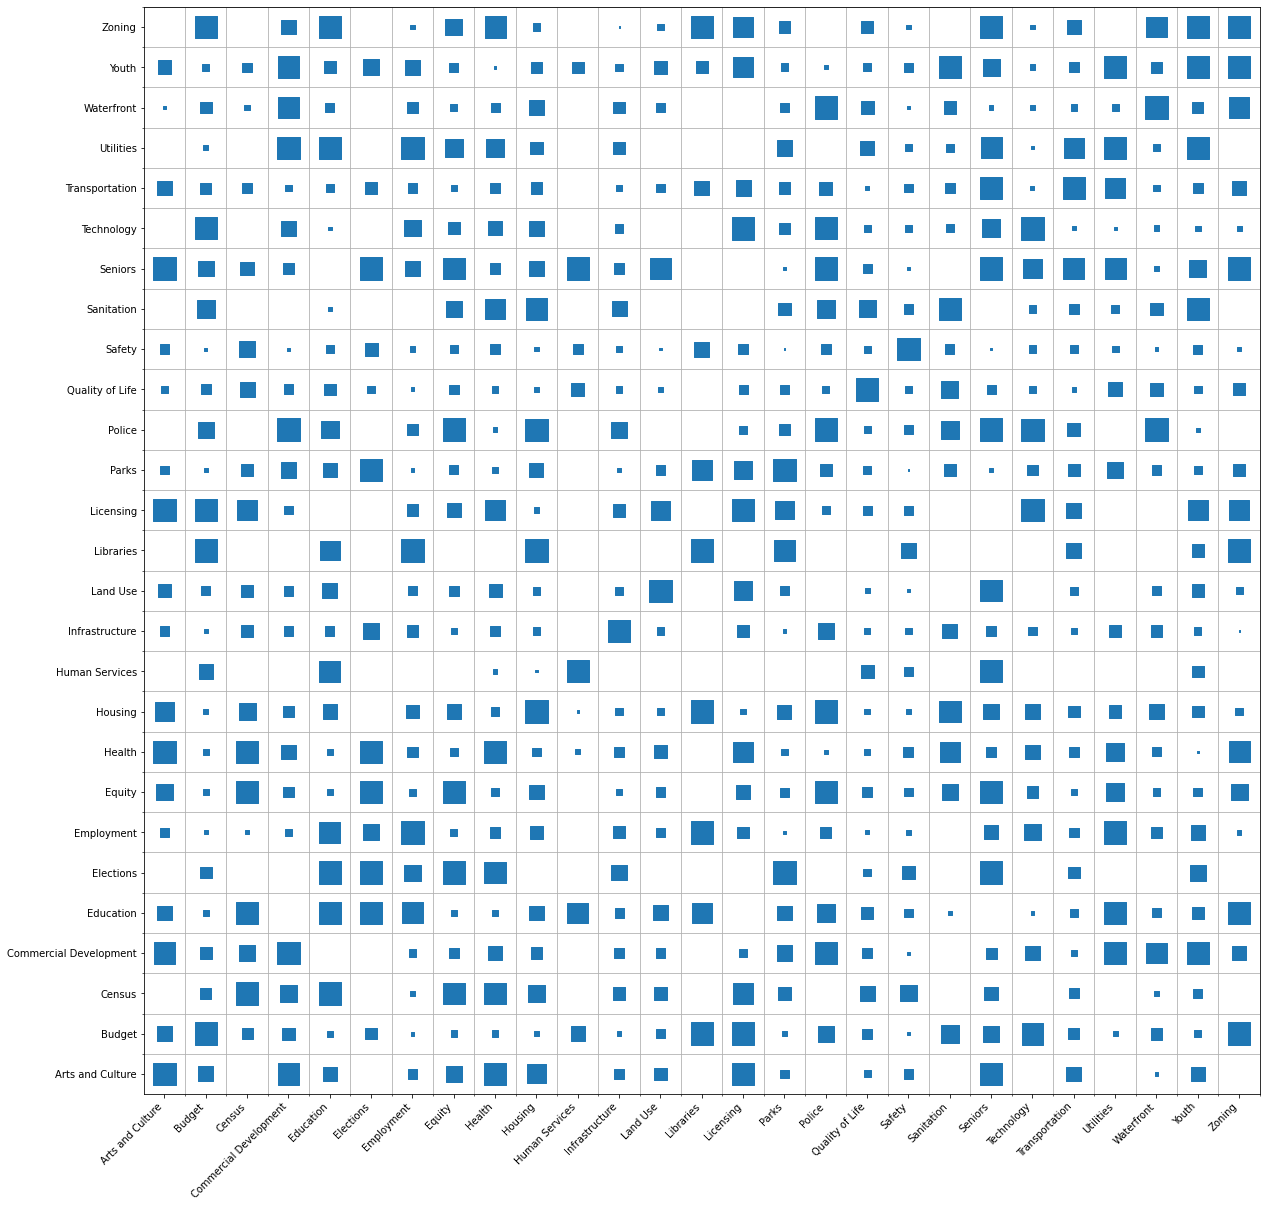

In [244]:
# Step 1 - Make a scatter plot with square markers, set column names as labels

def heatmap(x, y, size):
    fig, ax = plt.subplots(figsize=(20, 20))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale,
        #c=color.apply(value_to_color),# Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    a›x.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    
    
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    plt.savefig('images/topic_corr1.png', transparent=False, facecolor=fig.get_facecolor(), edgecolor='none')
    

corr = df[topics_tax].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

In [250]:
df.groupby('author', as_index=False)[topics_tax].count().to_csv('cb_topic_counts.csv',index=False)

In [251]:
topic_count = df.groupby('author', as_index=False)[topics_tax].count()

In [282]:
topic_count[topics_tax].sum()

Parks                     219
Housing                   217
Land Use                  135
Infrastructure            219
Transportation            222
Quality of Life           285
Safety                    352
Waterfront                 71
Technology                 49
Zoning                     99
Commercial Development     77
Equity                     96
Arts and Culture           40
Youth                     183
Census                     37
Seniors                    45
Employment                 99
Health                    168
Licensing                  94
Utilities                  31
Human Services             34
Budget                    142
Libraries                  13
Education                 137
Sanitation                 32
Police                     49
Elections                  22
dtype: int64

Text(0.5, 0, 'Number of meetings per CB')

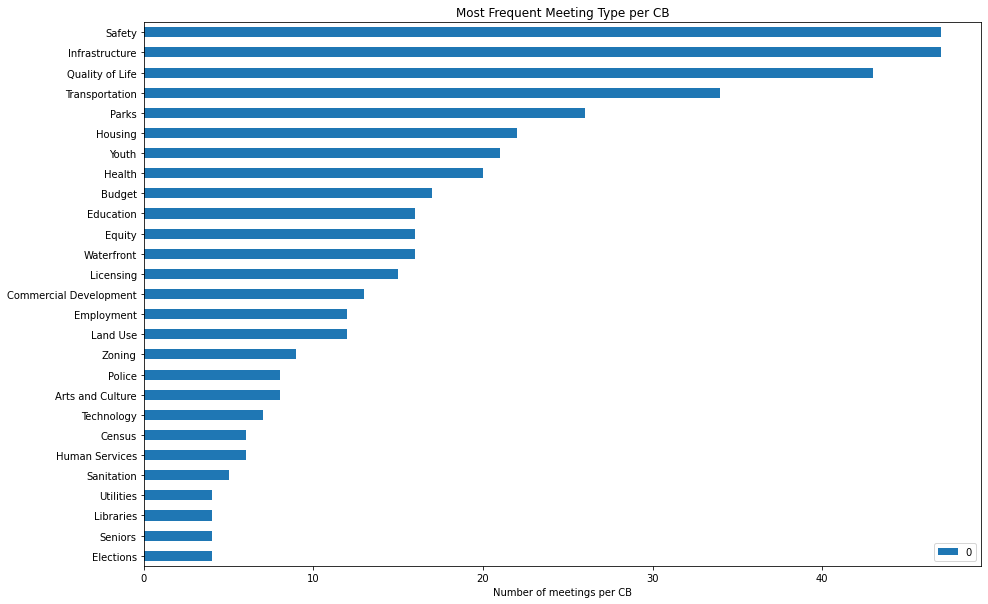

In [284]:
fig, ax = plt.subplots(figsize=(15, 10))
pd.DataFrame(topic_count[topics_tax].max()).sort_values(0).plot(kind='barh', ax=ax)
plt.title('Most Frequent Meeting Type per CB')
plt.xlabel('Number of meetings per CB')

Text(0.5, 0, 'Number of meetings')

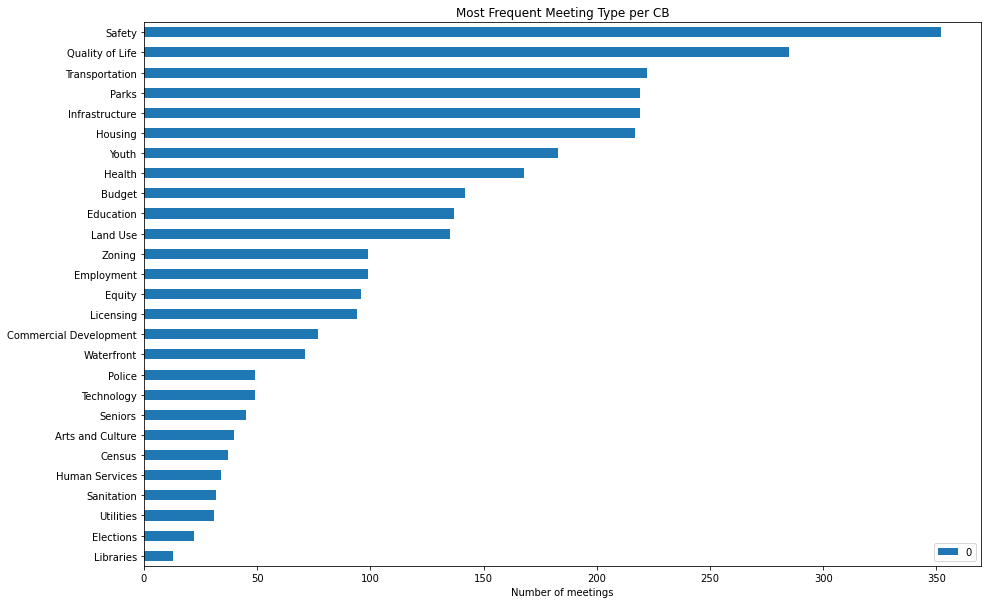

In [285]:
fig, ax = plt.subplots(figsize=(15, 10))
pd.DataFrame(topic_count[topics_tax].sum()).sort_values(0).plot(kind='barh', ax=ax)
plt.title('Most Frequent Meeting Type per CB')
plt.xlabel('Number of meetings')

In [286]:
topic_count[topic_count['author'] == 'Manhattan Community Board 4'][topics_tax]

,Parks,Housing,Land Use,Infrastructure,Transportation,Quality of Life,Safety,Waterfront,Technology,Zoning,Commercial Development,Equity,Arts and Culture,Youth,Census,Seniors,Employment,Health,Licensing,Utilities,Human Services,Budget,Libraries,Education,Sanitation,Police,Elections
18,9,22,9,6,9,13,23,4,2,4,3,4,2,5,3,1,4,11,4,2,3,13,0,9,5,5,0


In [287]:
topic_count['Housing'].mean()

7.233333333333333

<AxesSubplot:>

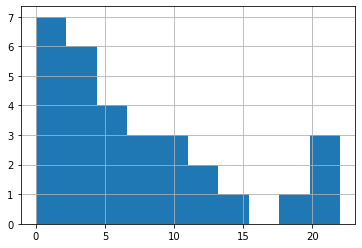

In [289]:
topic_count['Housing'].hist()

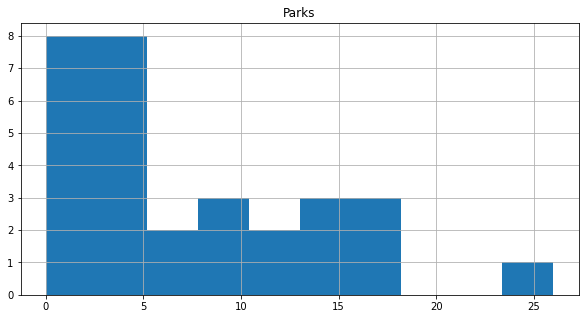

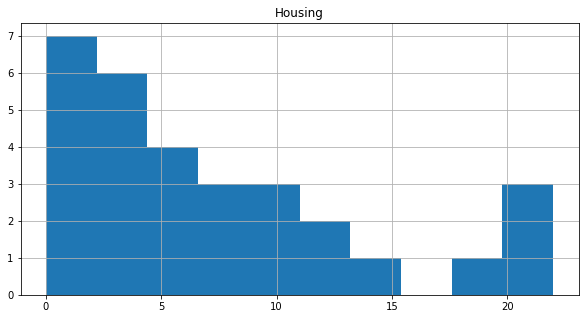

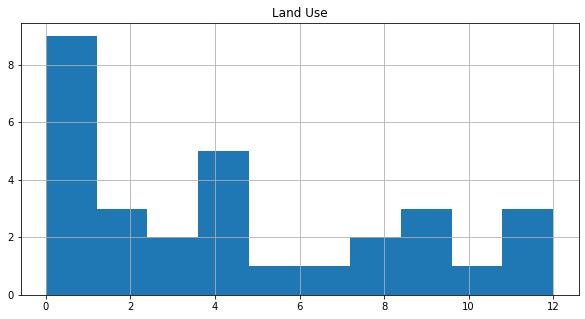

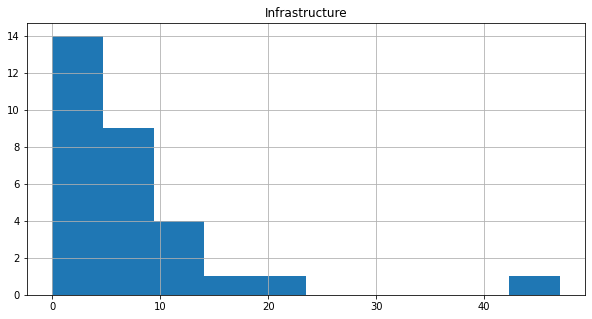

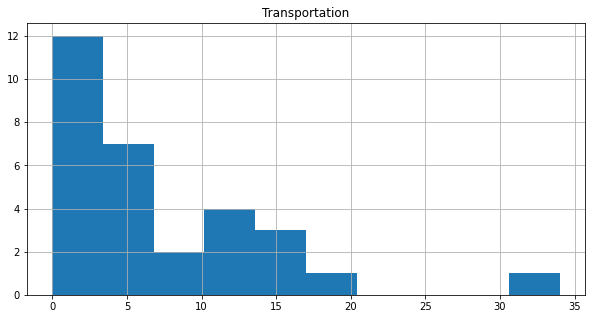

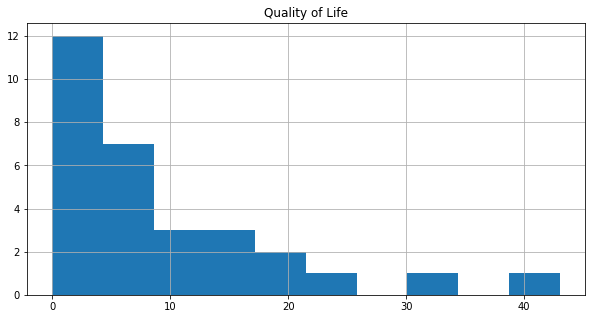

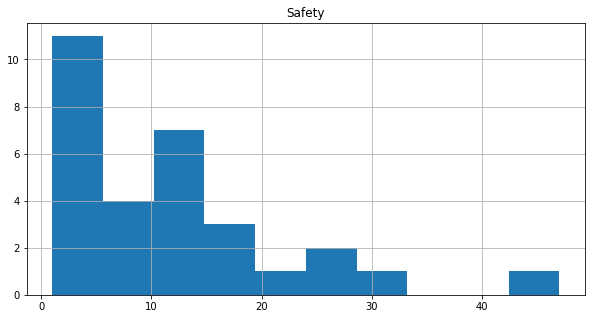

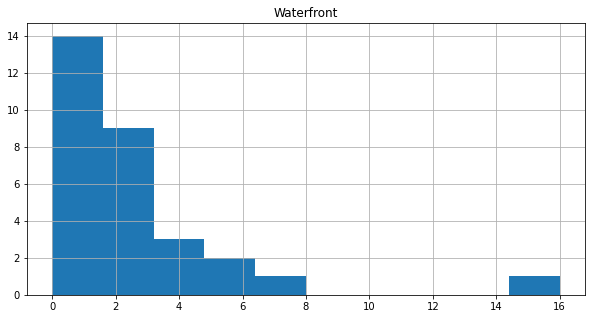

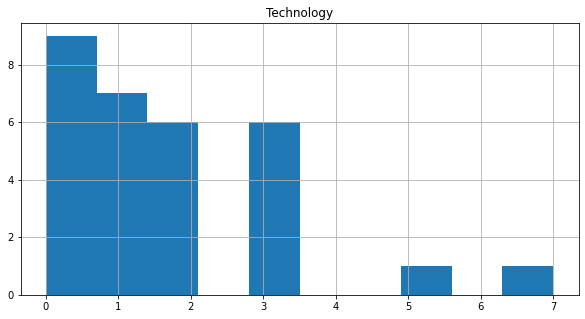

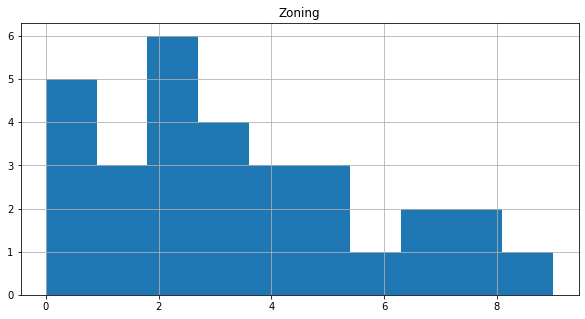

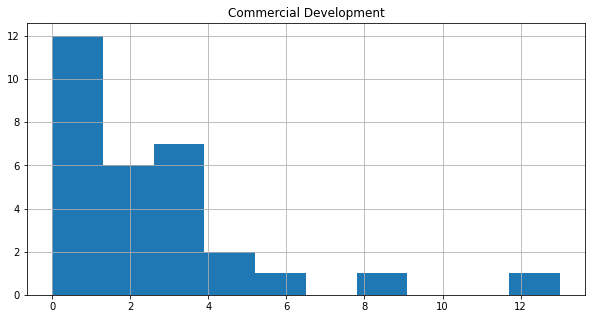

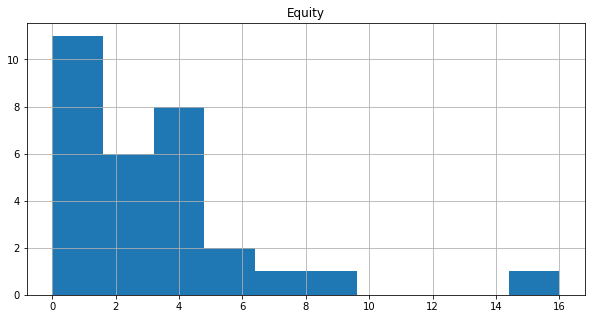

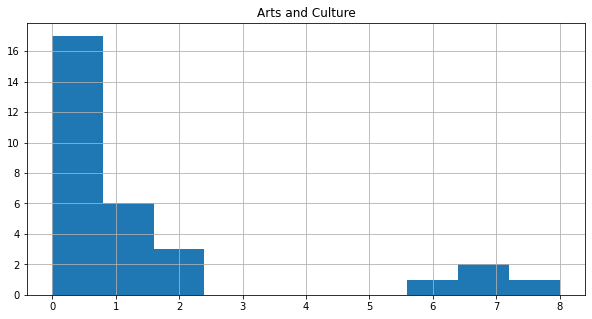

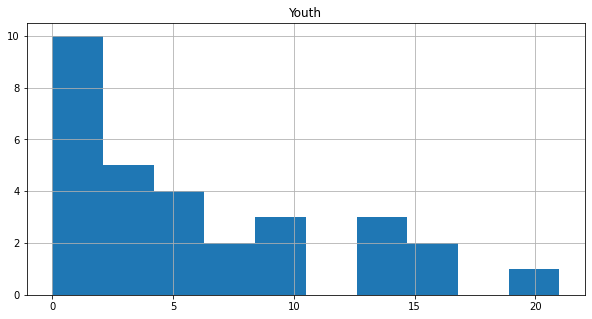

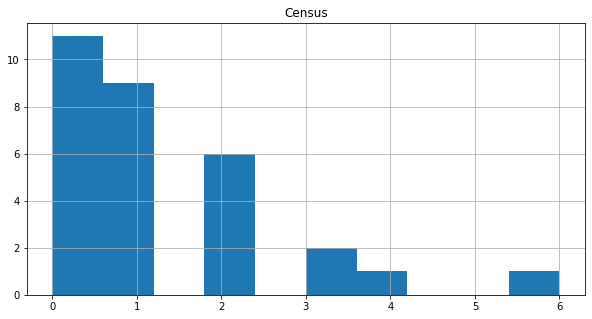

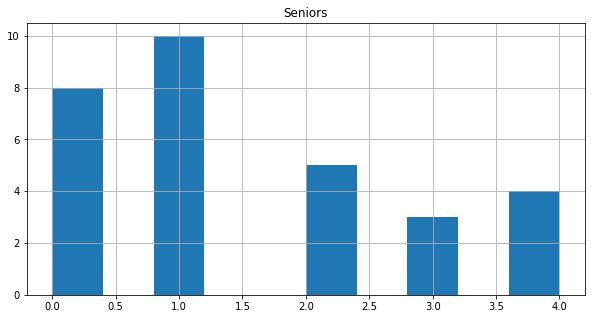

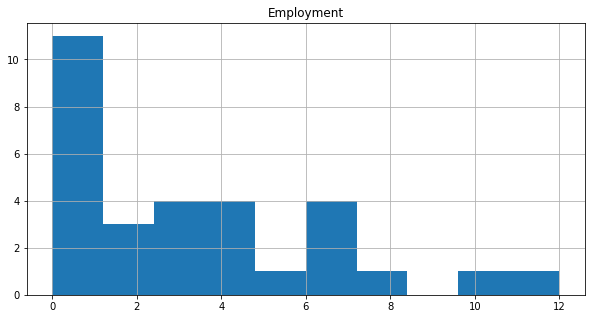

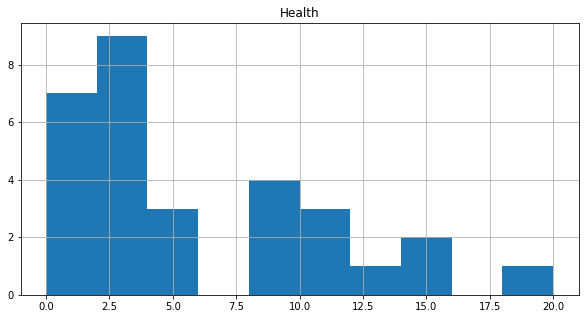

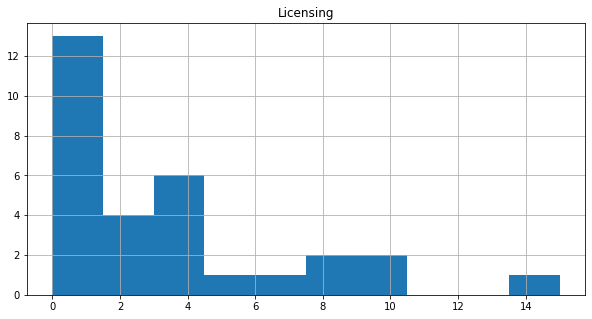

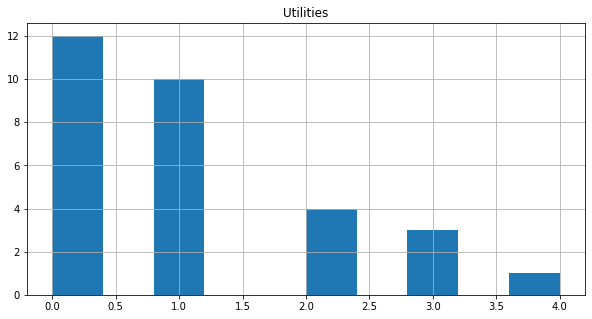

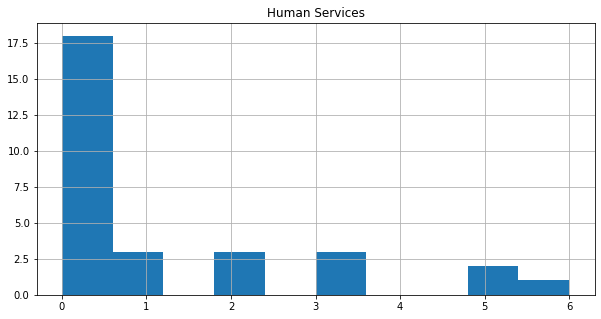

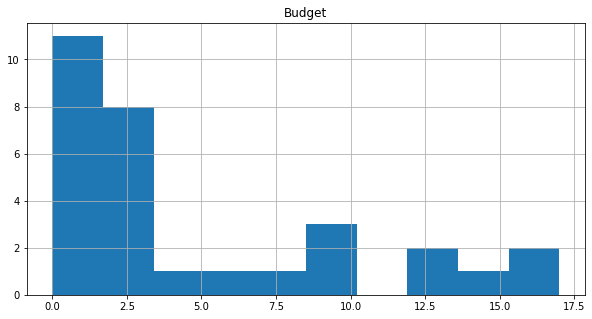

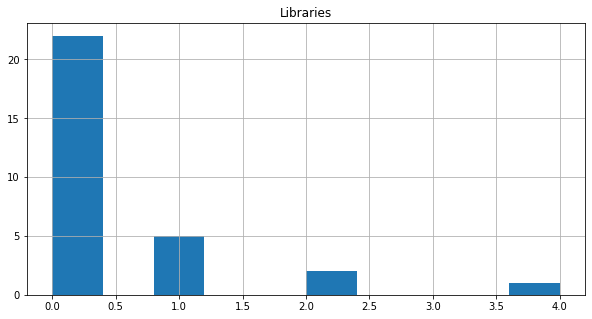

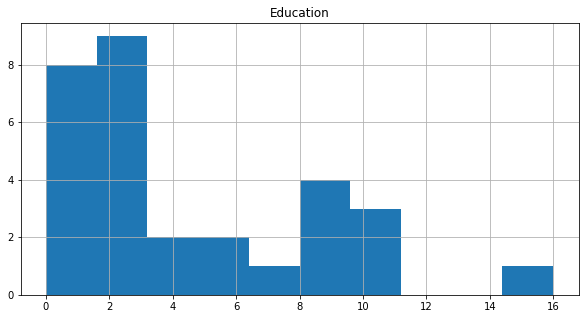

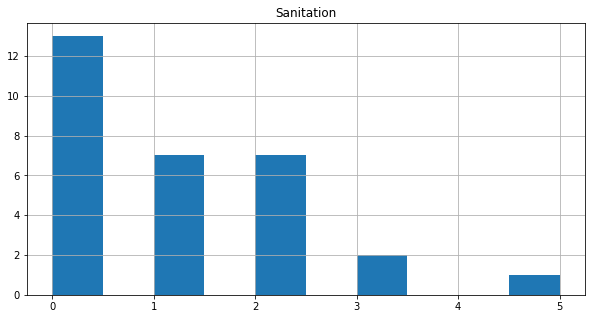

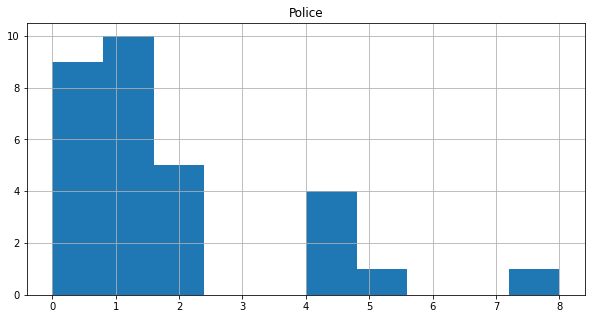

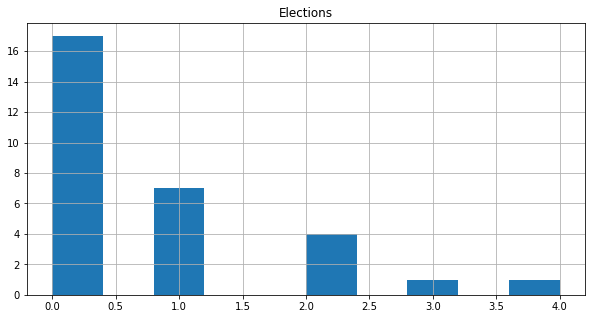

In [291]:
# Distributions
for i in topics_tax:
    plt.figure(figsize=(10, 5))
    topic_count[i].hist()
    plt.title(i)
    plt.show()